In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
import argparse
import pickle 
from utils_ import *
import scipy.linalg  as sla
import random

import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
%load_ext autoreload
%autoreload 2
# https://plotly.com/python/static-image-export/ need to install this if you want to save images
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoicmF0bGlmZmxqIiwiYSI6ImNqOGJ4cm8wcjAzN3QyeG1zcnZvMjB5bGUifQ.iRkpBPE-WANBkVc9ffI8ng")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# set flags
verbose=False # print out stuff for debugging
centered=False # centering the data

## Strategic Revenue Maximization Under Competition

Consider the following feature generation process:
$$z_1=z_{1,0}+A_1x_1+A_{-1}x_2, \ \ z_{1,0}\sim \mathcal{D}_{1,0}$$
and
$$z_2=z_{2,0}+A_2x_2+A_{-2}x_1, \ \ z_{2,0}\sim \mathcal{D}_{2,0}$$
where $\mathcal{D}_{i,0}=\mathcal{N}(0,\sigma_i^2 I)$. 

Each player $i$ seeks to minimize the following loss
$$-\frac{1}{2}z_i^\top x_i +\frac{\lambda}{2}\|x_i\|^2=-\frac{1}{2}(z_{i,0}+A_ix_i+A_{-i}x_{-i})^\top x_i +\frac{\lambda}{2}\|x_i\|^2$$
where $0<A_i\in \mathbb{R}^{d_i\times d_i}$ and $0>A_{-i}\in \mathbb{R}^{d_i\times d_{-i}}$ representing negative price elasticity to your own pricing chagnes and positive price elasticity to your competitors.

Hence, 
$$\nabla_iL_i=\mathbb{E}_{w_i,\theta}[-(A_i-\lambda I) x_i -\frac{1}{2} A_{-i}x_{-i}]$$
and the Hessian is 
$$\nabla_i^2L_i=\mathbb{E}_{w_i,\theta}[-(A_i^\top-\lambda I)]$$

## Initialize the game class and set the random seed and initial point

In [12]:
loc_cap=11
loc_lst_index=list(range(0,loc_cap))
price_lst_index=list(range(0,3))
ddgame=ddrideshare(loc_lst_index,price_lst_index,seed=2,lam=[0.0,0.0], base=True, params={'A1':[],'A2':[],'Ac1':[],'Ac2':[]},maxx=10)
ddgame.setup_distribution()

verbose=False
BATCH=10
MAXITER=5000
np.random.seed(10)
eta=0.001 
x0=np.random.rand(2,loc_cap)



## Experiment 1: Convergence

In [13]:
def zograd(x, z1_, z2_, A_1=ddgame.A1, A_1_=ddgame.Ac1, A_2=ddgame.A2, A_2_=ddgame.Ac2, delta=0.001, BATCH=1):
    p1 = np.zeros(ddgame.d)
    p2 = np.zeros(ddgame.d)
    for sample in range(BATCH):
        v1_ = np.random.normal(0,1,size=(ddgame.d,))
        v1 = v1_/la.norm(v1_)
        v2_ = np.random.normal(0,1,size=(ddgame.d,))
        v2 = v2_/la.norm(v2_)

        z1 = z1_+A_1@(x[0]+(delta*v1))+A_1_@(x[1]+(delta*v2))
        l1 = -0.5*z1@(x[0]+(delta*v1))+ddgame.lam1*la.norm(x[0]+(delta*v1))
        p1 += (ddgame.d/delta)*l1*v1

        z2 = z2_+A_2@(x[1]+(delta*v2))+A_2_@(x[0]+(delta*v1))
        l2 = -0.5*z2@(x[1]+(delta*v2))+ddgame.lam2*la.norm(x[1]+(delta*v2))
        p2 += (ddgame.d/delta)*l2*v2
        
    p1=p1/BATCH
    p2=p2/BATCH
    return np.vstack((p1,p2))

verbose=False
BATCH=20


loc_cap=11
nu=0.0001 #0.001 and B=4 #0.0005 B=5 #0.00025 B=5/6
eta= 5e-5 #1e-4
lam1=2
lam2=2
loc_lst_index=list(range(0,loc_cap))
price_lst_index=list(range(0,3))
x0=np.random.rand(2,loc_cap)
if 1: # computes Nash
    MAXITER=50000
    
    loc_lst_index=list(range(0,loc_cap))
    price_lst_index=list(range(0,3))
    ddgame=ddrideshare(loc_lst_index,price_lst_index,seed=2,lam=[lam1,lam2], base=True, params={'A1':[],'A2':[],'Ac1':[],'Ac2':[]},maxx=10)
    ddgame.setup_distribution()
    dic_sgd=ddgame.runSGD(x0,eta=0.001,BATCH=10,MAXITER=MAXITER, perform_sgd=[True,True])
    x_sgd=np.asarray(dic_sgd['x'])

    nash=[]
    for i in range(loc_cap):
        nash.append(np.mean(x_sgd[-100:,:,i],axis=0))
    nash=np.asarray(nash)


Price we are running at :  10


In [14]:
MAXITER=5000
eta=5e-5
ddgame=ddrideshare(loc_lst_index,price_lst_index,seed=2,lam=[lam1,lam2], base=True, params={'A1':[],'A2':[],'Ac1':[],'Ac2':[]},maxx=10)
ddgame.setup_distribution()
seeds=random.sample(range(1000), 2)

all_data={}
for seed in seeds:
    x0=np.random.rand(2,loc_cap)
    all_data[seed]={}
    all_data[seed]['x0']=x0
    x_agd=[x0]
    x_sgd=[x0]
    A1_hat = -10*np.random.rand(np.shape(ddgame.A1)[1])
    Ac1_hat = 2*np.random.rand(np.shape(ddgame.Ac1)[1])
    A2_hat = -10*np.random.rand(np.shape(ddgame.A2)[1])
    Ac2_hat = 2*np.random.rand(np.shape(ddgame.Ac2)[1])
    A1_hat=np.diag(A1_hat)
    Ac1_hat=np.diag(Ac1_hat)
    A2_hat=np.diag(A2_hat)
    Ac2_hat=np.diag(Ac2_hat)
    A_dic={}
    A_dic['A1_hat']=A1_hat
    A_dic['Ac1_hat']=Ac1_hat
    A_dic['A2_hat']=A2_hat
    A_dic['Ac2_hat']=Ac2_hat

    dic_agd=ddgame.runAGD(x0,A_dic,eta=eta,nu=nu,BATCH=BATCH,MAXITER=MAXITER, perform_agd=[True,True], INNERITER=1, B=6,UNCORR=True) #inner was 100
    dic_sgd=ddgame.runSGD(x0,eta=eta,BATCH=BATCH,MAXITER=MAXITER, perform_sgd=[True,True])
    x_agd=np.asarray(dic_agd['x'])
    x_sgd=np.asarray(dic_sgd['x'])

    alpha = np.min([la.norm(-ddgame.A1+ddgame.lam1*np.eye(ddgame.d)),la.norm(-ddgame.A2+ddgame.lam2*np.eye(ddgame.d))])-0.5*la.norm(ddgame.Ac1+ddgame.Ac2.T)

    eta_zo = 2
    delta = 10*0.5

    x_dfo=[x0]
    z1_base=ddgame.ql_[:,:,0].T
    z2_base=ddgame.qu_[:,:,0].T
    rev_dfo_p1=[ddgame.revenue(x_dfo[-1],0,z1_base)]
    rev_dfo_p2=[ddgame.revenue(x_dfo[-1],1,z2_base)]
    for i in range(MAXITER):
        z1_=ddgame.D_z(z1_base, batch=BATCH)
        z2_=ddgame.D_z(z2_base, batch=BATCH)


        x_dfo.append(ddgame.proj(x_dfo[-1]-(eta_zo/(alpha*(i+1))*zograd(x_dfo[-1], z1_, z2_, ddgame.A1, ddgame.Ac1, ddgame.A2, ddgame.Ac2, delta, BATCH=50))))
        rev_dfo_p1.append(ddgame.revenue(x_dfo[-1],0,z1_base))
        rev_dfo_p2.append(ddgame.revenue(x_dfo[-1],1,z2_base))

    x_dfo=np.asarray(x_dfo)

    error_dfo=[]
    error_sgd=[]
    error_agd=[]
    for x,y in zip(x_dfo,x_sgd):
        error_dfo.append(la.norm(x-nash.T)**2)
        error_sgd.append(la.norm(y-nash.T)**2)

    err_dfo=np.asarray(error_dfo)
    err_sgd=np.asarray(error_sgd)

    for x in x_agd:
        error_agd.append(la.norm(x-nash.T)**2)

    err_agd=np.asarray(error_agd)
    all_data[seed]['error_agd']=err_agd
    all_data[seed]['error_sgd']=err_sgd
    all_data[seed]['error_dfo']=err_dfo

Price we are running at :  10
Price we are running at :  10
Price we are running at :  10
Price we are running at :  10


(5001,)


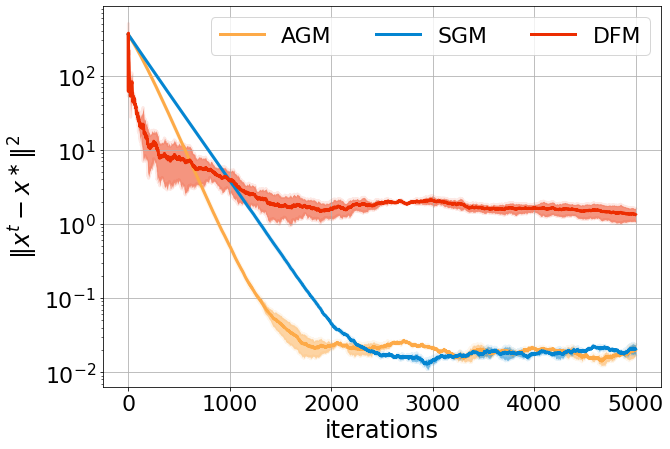

In [225]:
SAVE=0
filename='./figs/convergence_rideshare_DFO_loc11.'
errs_agd=[]
errs_sgd=[]
errs_dfo=[]
for seed in seeds:
    errs_agd.append(all_data[seed]['error_agd'])
    errs_sgd.append(all_data[seed]['error_sgd'])
    errs_dfo.append(all_data[seed]['error_dfo'])
errs_agd=np.asarray(errs_agd)
errs_sgd=np.asarray(errs_sgd)
errs_dfo=np.asarray(errs_dfo)


errs_agd_mean=np.mean(errs_agd,axis=0)
errs_sgd_mean=np.mean(errs_sgd,axis=0)
errs_dfo_mean=np.mean(errs_dfo,axis=0)

errs_agd_var=np.std(errs_agd,axis=0)
errs_sgd_var=np.std(errs_sgd,axis=0)
print(np.shape(errs_agd_var))
errs_dfo_var=np.std(errs_dfo,axis=0)
iterations=np.arange(0,MAXITER+1)
fig=plt.figure(figsize=(10,7))
for i in range(len(errs_agd)):
    plt.plot(errs_agd[i,:], linewidth=3, alpha=0.1, color='xkcd:light orange')
    plt.plot(errs_sgd[i,:], linewidth=3,color='xkcd:cerulean', alpha=0.1)
    plt.plot(errs_dfo[i,:], linewidth=3,color='xkcd:tomato red',alpha=0.1)
plt.plot(errs_agd_mean, linewidth=3, color='xkcd:light orange', label='AGM')
plt.yscale('log')
plt.fill_between(iterations,errs_agd_mean+errs_agd_var,errs_agd_mean-errs_agd_var, alpha=0.5, linewidth=0, color='xkcd:light orange')
plt.grid(True)
plt.plot(errs_sgd_mean, linewidth=3,color='xkcd:cerulean', label='SGM')
plt.fill_between(iterations,errs_sgd_mean+errs_sgd_var,errs_sgd_mean-errs_sgd_var, alpha=0.5, linewidth=0,color='xkcd:cerulean')
plt.plot(errs_dfo_mean, linewidth=3,color='xkcd:tomato red', label='DFM')
plt.fill_between(iterations,errs_dfo_mean+errs_dfo_var,errs_dfo_mean-errs_dfo_var, alpha=0.5, linewidth=0,color='xkcd:tomato red',)
plt.tick_params(labelsize=fs-2)
plt.ylabel(r'$\Vert x^t-x^\ast\Vert^2$', fontsize=fs)
plt.xlabel(r'iterations', fontsize=fs)
plt.legend(fontsize=fs-2, loc='upper right',ncol=3)
if SAVE:
    for tag in ['pdf','png']:
        plt.savefig(filename+tag,  bbox_inches='tight', dpi=300)

## Experiment 2: Comparison to Social Optimum 

In [15]:
verbose=False
BATCH=10
MAXITER=1000
MAXITER_NE=6000
tot_rev=0
# set up the game
loc_cap=11
loc_lst_index=list(range(0,loc_cap))
price_lst_index=list(range(0,3))
ddgame=ddrideshare(loc_lst_index,price_lst_index,seed=2,lam=[0.0,0.0], base=True, params={'A1':[],'A2':[],'Ac1':[],'Ac2':[]},maxx=10)
ddgame.setup_distribution()

# seed 
np.random.seed(10)
eta=0.001 
x0=np.random.rand(2,loc_cap)


In [16]:
## Compute Nash 
dic_sgd=ddgame.runSGD(x0,eta=0.001,BATCH=10,MAXITER=MAXITER_NE, perform_sgd=[True,True],tot_rev=0)
x_sgd=np.asarray(dic_sgd['x'])
nash=[]
for i in range(loc_cap):
    nash.append(np.mean(x_sgd[-100:,:,i],axis=0))
nash=np.asarray(nash)
    

Price we are running at :  10


In [17]:
# run all three cases
dic_sgd=ddgame.runSGD(x0,eta=0.001,BATCH=10,MAXITER=MAXITER, perform_sgd=[True,True],tot_rev=0)
dic_rgd=ddgame.runRGD(x0,eta=0.001,BATCH=10,MAXITER=MAXITER,tot_rev=0)
dic_so=ddgame.runSO(x0,eta=0.001,MAXITER=MAXITER,tot_rev=0)

x_so=np.asarray(dic_so['x'])
x_sgd=np.asarray(dic_sgd['x'])
x_rgd=np.asarray(dic_rgd['x'])

error_so=[]
error_sgd=[]
error_rgd=[]
for x,y in zip(x_so,x_sgd):
    error_so.append(la.norm(x.T-nash)**2)
    error_sgd.append(la.norm(y-nash.T)**2)
    
err_so=np.asarray(error_so)
err_sgd=np.asarray(error_sgd)

for x in x_rgd:
    error_rgd.append(la.norm(x-nash.T)**2)
    
err_rgd=np.asarray(error_rgd)

Price we are running at :  10
Price we are running at :  10
maxiter :  1000
maxiter rgd:  1000
Price we are running at :  10


In [18]:
# get mean prices
x_so_avg_p1=np.mean(x_so[:,0,:],axis=1)
x_so_avg_p2=np.mean(x_so[:,1,:],axis=1)
x_sgd_avg_p1=np.mean(x_sgd[:,0,:],axis=1)
x_sgd_avg_p2=np.mean(x_sgd[:,1,:],axis=1)
x_rgd_avg_p1=np.mean(x_rgd[:,0,:],axis=1)
x_rgd_avg_p2=np.mean(x_rgd[:,1,:],axis=1)

14


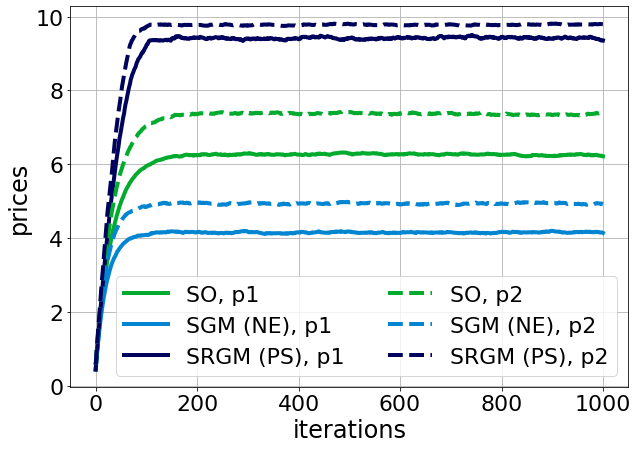

In [20]:
SAVE=0
fs=24
fname='./figs/test_end_files/prices_RGD_SGD_SO_loc.'
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ls_=['-','--']
lw=4
oss=[0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.4,0.3,0.2,0.1,0.0]
print(len(oss))


plt.plot(x_so_avg_p1[:], label='SO, p1',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:kelly green')
plt.plot(x_sgd_avg_p1[:], label='SGM (NE), p1',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:cerulean')
plt.plot(x_rgd_avg_p1[:], label='SRGM (PS), p1',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:dark blue')
plt.plot(x_so_avg_p2[:], label='SO, p2',ls=ls_[1],alpha=1.0, lw=lw, color='xkcd:kelly green')
plt.plot(x_sgd_avg_p2[:], label='SGM (NE), p2',ls=ls_[1],alpha=1.0, lw=lw, color='xkcd:cerulean')
plt.plot(x_rgd_avg_p2[:], label='SRGM (PS), p2',ls=ls_[1],alpha=1.0, lw=lw, color='xkcd:dark blue')
ax.grid(True)
ax.set_xlabel(r'iterations', fontsize=fs)
ax.legend(fontsize=fs-2,ncol=2) #loc='center',bbox_to_anchor=(0.5,-0.2),ncol=6)
plt.tick_params(labelsize=fs-2)


plt.ylabel(r'prices', fontsize=fs)
if SAVE:
    for tag in ['png','pdf']:
        plt.savefig(fname+tag, dpi=300, transparent=True, bbox_inches='tight')

In [21]:
rev_so_p1=np.asarray(dic_so['revenue_total_p1'])
rev_so_p2=np.asarray(dic_so['revenue_total_p2'])
social_rev=rev_so_p1+rev_so_p2

rev_sgd_p1=np.asarray(dic_sgd['revenue_total_p1'])
rev_sgd_p2=np.asarray(dic_sgd['revenue_total_p2'])

rev_rgd_p1=np.asarray(dic_rgd['revenue_total_p1'])
rev_rgd_p2=np.asarray(dic_rgd['revenue_total_p2'])

14


Text(0, 0.5, 'revenue')

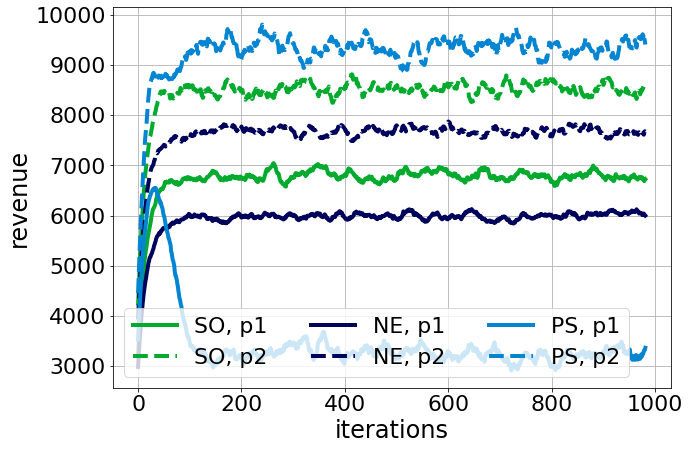

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ls_=['-','--']
lw=4
oss=[0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.4,0.3,0.2,0.1,0.0]
print(len(oss))
mean_val=20
rev_so_p1_=running_mean(rev_so_p1,N=mean_val)
rev_so_p2_=running_mean(rev_so_p2,N=mean_val)
rev_sgd_p1_=running_mean(rev_sgd_p1,N=mean_val)
rev_sgd_p2_=running_mean(rev_sgd_p2,N=mean_val)
rev_rgd_p1_=running_mean(rev_rgd_p1,N=mean_val)
rev_rgd_p2_=running_mean(rev_rgd_p2,N=mean_val)
plt.plot(rev_so_p1_, label='SO, p1',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:kelly green')
plt.plot(rev_so_p2_, label='SO, p2',ls=ls_[1],alpha=1, lw=lw, color='xkcd:kelly green')
plt.plot(rev_sgd_p1_, label='NE, p1',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:dark blue')
plt.plot(rev_sgd_p2_, label='NE, p2',ls=ls_[1],alpha=1, lw=lw, color='xkcd:dark blue')
plt.plot(rev_rgd_p1_, label='PS, p1',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:cerulean')
plt.plot(rev_rgd_p2_, label='PS, p2',ls=ls_[1],alpha=1.0, lw=lw, color='xkcd:cerulean')
ax.grid(True)
ax.set_xlabel(r'iterations', fontsize=fs)
ax.legend(fontsize=fs-2,ncol=3) #loc='center',bbox_to_anchor=(0.5,-0.2),ncol=6)
plt.tick_params(labelsize=fs-2)


plt.ylabel(r'revenue', fontsize=fs)
#for tag in ['png','pdf']:
#   plt.savefig(fname+tag, dpi=300, transparent=True, bbox_inches='tight')

In [23]:
loss_so_p1=np.asarray(dic_so['loss_p1'])
loss_so_p2=np.asarray(dic_so['loss_p2'])
social_loss=loss_so_p1+loss_so_p2

loss_sgd_p1=np.asarray(dic_sgd['loss_p1'])
loss_sgd_p2=np.asarray(dic_sgd['loss_p2'])

loss_rgd_p1=np.asarray(dic_rgd['loss_p1'])
loss_rgd_p2=np.asarray(dic_rgd['loss_p2'])

14


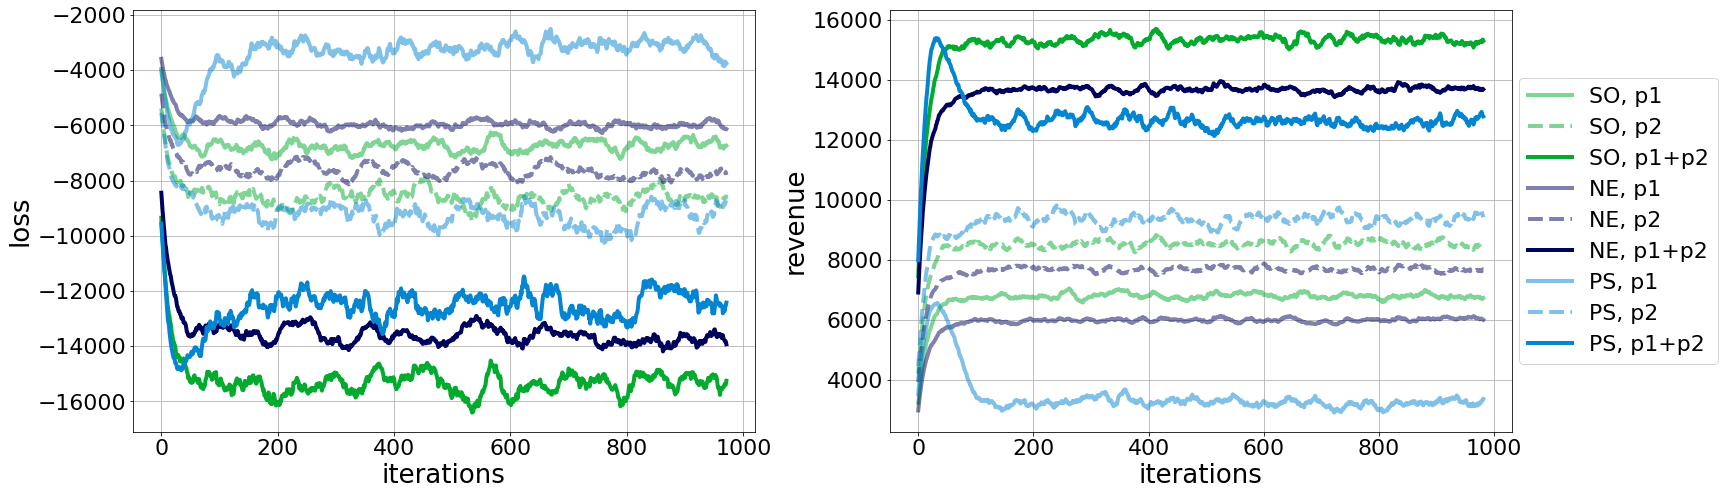

In [24]:
fname='./figs/test_end_files/social_cost_rideshare.'
SAVE=0
fig, ax = plt.subplots(1, 2, figsize=(24, 7))
ls_=['-','--']
lw=4
oss=[0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.4,0.3,0.2,0.1,0.0]
print(len(oss))
mean_val=30
loss_so_p1_=running_mean(loss_so_p1,N=mean_val)
loss_so_p2_=running_mean(loss_so_p2,N=mean_val)
loss_sgd_p1_=running_mean(loss_sgd_p1,N=mean_val)
loss_sgd_p2_=running_mean(loss_sgd_p2,N=mean_val)
loss_rgd_p1_=running_mean(loss_rgd_p1,N=mean_val)
loss_rgd_p2_=running_mean(loss_rgd_p2,N=mean_val)
ax[0].plot(loss_so_p1_, label='SO, p1',ls=ls_[0],alpha=0.5, lw=lw, color='xkcd:kelly green')
ax[0].plot(loss_so_p2_, label='SO, p2',ls=ls_[1],alpha=0.5, lw=lw, color='xkcd:kelly green')
ax[0].plot(loss_so_p1_+loss_so_p2_, label='SO',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:kelly green')

ax[0].plot(loss_sgd_p1_, label='NE, p1',ls=ls_[0],alpha=0.5, lw=lw, color='xkcd:dark blue')
ax[0].plot(loss_sgd_p2_, label='NE, p2',ls=ls_[1],alpha=0.5, lw=lw, color='xkcd:dark blue')
ax[0].plot(loss_sgd_p2_+loss_sgd_p1_, label='NE',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:dark blue')

ax[0].plot(loss_rgd_p1_, label='PS, p1',ls=ls_[0],alpha=0.5, lw=lw, color='xkcd:cerulean')
ax[0].plot(loss_rgd_p2_, label='PS, p2',ls=ls_[1],alpha=0.5, lw=lw, color='xkcd:cerulean')
ax[0].plot(loss_rgd_p1_+loss_rgd_p2_, label='PS',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:cerulean')

ax[0].grid(True)
ax[0].set_xlabel(r'iterations', fontsize=fs+2)

ax[0].tick_params(labelsize=fs-2)
ax[0].set_ylabel(r'loss', fontsize=fs+2)

mean_val=20
rev_so_p1_=running_mean(rev_so_p1,N=mean_val)
rev_so_p2_=running_mean(rev_so_p2,N=mean_val)
rev_sgd_p1_=running_mean(rev_sgd_p1,N=mean_val)
rev_sgd_p2_=running_mean(rev_sgd_p2,N=mean_val)
rev_rgd_p1_=running_mean(rev_rgd_p1,N=mean_val)
rev_rgd_p2_=running_mean(rev_rgd_p2,N=mean_val)
ax[1].plot(rev_so_p1_, label='SO, p1',ls=ls_[0],alpha=0.5, lw=lw, color='xkcd:kelly green')
ax[1].plot(rev_so_p2_, label='SO, p2',ls=ls_[1],alpha=0.5, lw=lw, color='xkcd:kelly green')
ax[1].plot(rev_so_p1_+rev_so_p2_, label='SO, p1+p2',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:kelly green')

ax[1].plot(rev_sgd_p1_, label='NE, p1',ls=ls_[0],alpha=0.5, lw=lw, color='xkcd:dark blue')
ax[1].plot(rev_sgd_p2_, label='NE, p2',ls=ls_[1],alpha=0.5, lw=lw, color='xkcd:dark blue')
ax[1].plot(rev_sgd_p1_+rev_sgd_p2_, label='NE, p1+p2',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:dark blue')

ax[1].plot(rev_rgd_p1_, label='PS, p1',ls=ls_[0],alpha=0.5, lw=lw, color='xkcd:cerulean')
ax[1].plot(rev_rgd_p2_, label='PS, p2',ls=ls_[1],alpha=0.5, lw=lw, color='xkcd:cerulean')
ax[1].plot(rev_rgd_p1_+rev_rgd_p2_, label='PS, p1+p2',ls=ls_[0],alpha=1.0, lw=lw, color='xkcd:cerulean')
ax[1].grid(True)
ax[1].set_xlabel(r'iterations', fontsize=fs+2)
#ax[1].legend(fontsize=fs-2,ncol=3) #loc='center',bbox_to_anchor=(0.5,-0.2),ncol=6)
ax[1].tick_params(labelsize=fs-2)
ax[1].legend(fontsize=fs-2,ncol=1, loc='right',bbox_to_anchor=(1.35,0.5)) #loc='center',bbox_to_anchor=(0.5,-0.2),ncol=6)

ax[1].set_ylabel(r'revenue', fontsize=fs+2)
plt.tight_layout()

if SAVE:
    for tag in ['png','pdf']:
        plt.savefig(fname+tag, dpi=300, transparent=True, bbox_inches='tight')

### Create Bar Charts for Experiment 2

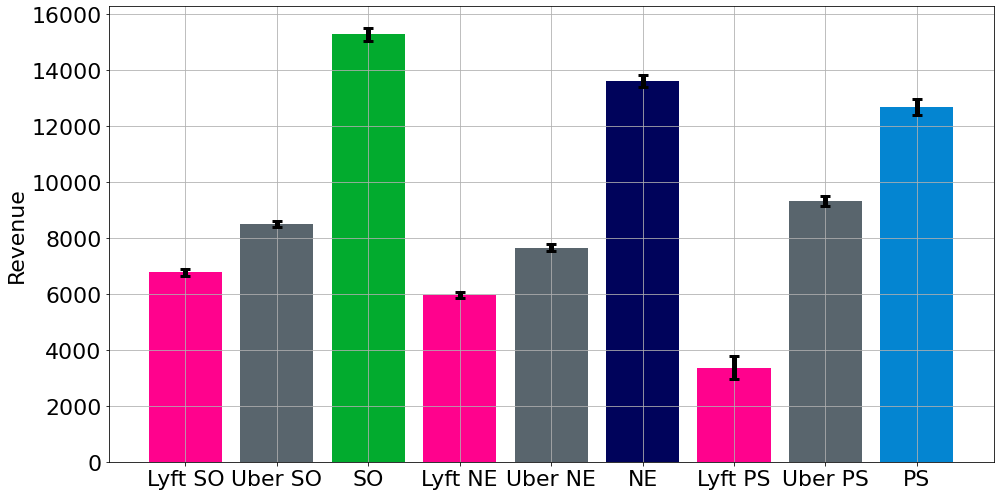

In [25]:
# where to store
SAVE=0
filename='./figs/test_end_files/exp_f_change_rev_demand_price10.'
fs=24
bdd=1000 # how many points to average

lyft_rev_so=running_mean(rev_so_p1,N=100) # Nash - myopic
uber_rev_so=running_mean(rev_so_p2,N=100)
lyft_rev_so_final=np.mean(lyft_rev_so[-bdd:])
uber_rev_so_final=np.mean(uber_rev_so[-bdd:])
lyft_rev_var_so = np.std(lyft_rev_so[-bdd:])
uber_rev_var_so = np.std(uber_rev_so[-bdd:])
var=[lyft_rev_var_so, uber_rev_var_so]

lyft_rev_sgd=running_mean(rev_sgd_p1,N=100) # Nash - myopic
uber_rev_sgd=running_mean(rev_sgd_p2,N=100)
lyft_rev_sgd_final=np.mean(lyft_rev_sgd[-bdd:])
uber_rev_sgd_final=np.mean(uber_rev_sgd[-bdd:])
lyft_rev_var_sgd = np.std(lyft_rev_sgd[-bdd:])
uber_rev_var_sgd = np.std(uber_rev_sgd[-bdd:])
var=[lyft_rev_var_sgd, uber_rev_var_sgd]

lyft_rev_rgd=running_mean(rev_rgd_p1,N=100) # Nash - myopic
uber_rev_rgd=running_mean(rev_rgd_p2,N=100)
lyft_rev_rgd_final=np.mean(lyft_rev_rgd[-bdd:])
uber_rev_rgd_final=np.mean(uber_rev_rgd[-bdd:])
lyft_rev_var_rgd = np.std(lyft_rev_rgd[-bdd:])
uber_rev_var_rgd = np.std(uber_rev_rgd[-bdd:])
var=[lyft_rev_var_rgd, uber_rev_var_rgd]


fig, ax = plt.subplots(1, 1, figsize=(14, 7))

data=['Lyft Revenue', 'Uber Revenue']
data_=['Lyft Demand', 'Uber Demand']
x_pos = [i for i, _ in enumerate(data)]
x_pos_ = [i for i, _ in enumerate(data_)]

tot_so=lyft_rev_so_final+uber_rev_so_final
tot_ne=lyft_rev_sgd_final+uber_rev_sgd_final
tot_ps=lyft_rev_rgd_final+uber_rev_rgd_final
var_so=np.std(lyft_rev_so[-bdd:]+uber_rev_so[-bdd:])
var_sgd=np.std(lyft_rev_sgd[-bdd:]+uber_rev_sgd[-bdd:])
var_rgd=np.std(lyft_rev_rgd[-bdd:]+uber_rev_rgd[-bdd:])
vals=[lyft_rev_so_final, uber_rev_so_final,tot_so,lyft_rev_sgd_final, uber_rev_sgd_final,tot_ne,lyft_rev_rgd_final,uber_rev_rgd_final,tot_ps]
var=[lyft_rev_var_so, uber_rev_var_so,var_so,lyft_rev_var_sgd, uber_rev_var_sgd,var_sgd,lyft_rev_var_rgd, uber_rev_var_rgd,var_rgd]
vals_=[lyft_rev_sgd_final, uber_rev_sgd_final]
_vals=[lyft_rev_sgd_final,uber_rev_sgd_final]

dic={key: val for key, val in zip(data,vals)}
ax.grid(True)


ax.set_ylabel("Revenue", fontsize=fs-2)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['Lyft SO','Uber SO','SO','Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS'], fontsize=fs-2)
ax.bar([0,1,2,3,4,5,6,7,8], vals , yerr=var, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:kelly green','xkcd:hot pink', 
                                                       'xkcd:slate grey','xkcd:dark blue','xkcd:hot pink', 'xkcd:slate grey','xkcd:cerulean'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )

plt.tick_params(labelsize=fs-2)
ax.tick_params(labelsize=fs-2)
plt.tight_layout()

fname='./figs/test_end_files/revenue_so_comp.'
if SAVE:
    for tag in ['pdf', 'png']:
        plt.savefig(filename+tag, dpi=300, bbox_inches='tight', transparent=True)

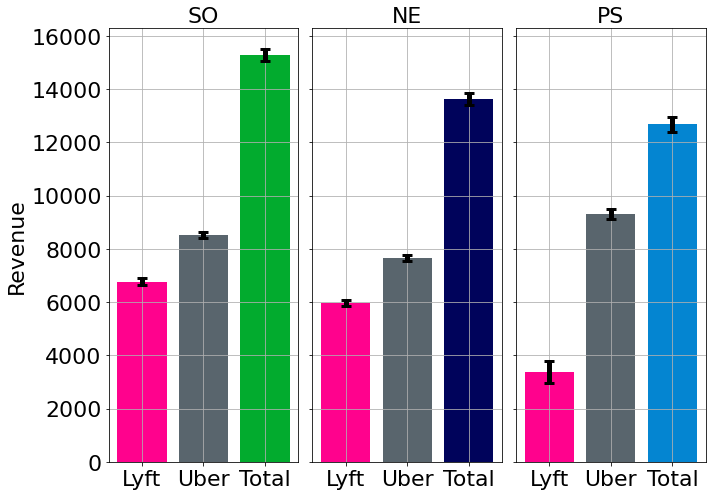

In [26]:
# where to store
filename='./figs/test_end_files/exp_f_change_rev_demand_price10.'
fs=24
bdd=1000 # how many points to average

lyft_rev_so=running_mean(rev_so_p1,N=100) # Nash - myopic
uber_rev_so=running_mean(rev_so_p2,N=100)
lyft_rev_so_final=np.mean(lyft_rev_so[-bdd:])
uber_rev_so_final=np.mean(uber_rev_so[-bdd:])
lyft_rev_var_so = np.std(lyft_rev_so[-bdd:])
uber_rev_var_so = np.std(uber_rev_so[-bdd:])
var=[lyft_rev_var_so, uber_rev_var_so]

lyft_rev_sgd=running_mean(rev_sgd_p1,N=100) # Nash - myopic
uber_rev_sgd=running_mean(rev_sgd_p2,N=100)
lyft_rev_sgd_final=np.mean(lyft_rev_sgd[-bdd:])
uber_rev_sgd_final=np.mean(uber_rev_sgd[-bdd:])
lyft_rev_var_sgd = np.std(lyft_rev_sgd[-bdd:])
uber_rev_var_sgd = np.std(uber_rev_sgd[-bdd:])
var=[lyft_rev_var_sgd, uber_rev_var_sgd]

lyft_rev_rgd=running_mean(rev_rgd_p1,N=100) # Nash - myopic
uber_rev_rgd=running_mean(rev_rgd_p2,N=100)
lyft_rev_rgd_final=np.mean(lyft_rev_rgd[-bdd:])
uber_rev_rgd_final=np.mean(uber_rev_rgd[-bdd:])
lyft_rev_var_rgd = np.std(lyft_rev_rgd[-bdd:])
uber_rev_var_rgd = np.std(uber_rev_rgd[-bdd:])
var=[lyft_rev_var_rgd, uber_rev_var_rgd]

fig, ax = plt.subplots(1, 3, figsize=(10, 7), sharey=True)

data=['Lyft Revenue', 'Uber Revenue']
data_=['Lyft Demand', 'Uber Demand']
x_pos = [i for i, _ in enumerate(data)]
x_pos_ = [i for i, _ in enumerate(data_)]

tot_so=lyft_rev_so_final+uber_rev_so_final
tot_ne=lyft_rev_sgd_final+uber_rev_sgd_final
tot_ps=lyft_rev_rgd_final+uber_rev_rgd_final
var_so=np.std(lyft_rev_so[-bdd:]+uber_rev_so[-bdd:])
var_sgd=np.std(lyft_rev_sgd[-bdd:]+uber_rev_sgd[-bdd:])
var_rgd=np.std(lyft_rev_rgd[-bdd:]+uber_rev_rgd[-bdd:])

vals_so=[lyft_rev_so_final, uber_rev_so_final,tot_so]
vals_ne=[lyft_rev_sgd_final, uber_rev_sgd_final,tot_ne]
vals_ps=[lyft_rev_rgd_final,uber_rev_rgd_final,tot_ps]

var_so=[lyft_rev_var_so, uber_rev_var_so,var_so]
var_ne=[lyft_rev_var_sgd, uber_rev_var_sgd,var_sgd]
var_ps=[lyft_rev_var_rgd, uber_rev_var_rgd,var_rgd]


dic={key: val for key, val in zip(data,vals)}
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_ylabel("Revenue", fontsize=fs-2)


ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['Lyft','Uber','Total'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax[0].bar([0,1,2], vals_so , yerr=var_so, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:kelly green'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )

ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['Lyft','Uber','Total'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax[1].bar([0,1,2], vals_ne , yerr=var_ne, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:dark blue'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )

ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels(['Lyft','Uber','Total'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax[2].bar([0,1,2], vals_ps , yerr=var_ps, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:cerulean'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )

ax[2].set_title("PS", fontsize=fs-2)
ax[1].set_title("NE", fontsize=fs-2)
ax[0].set_title("SO", fontsize=fs-2)
plt.tick_params(labelsize=fs-2)
ax[0].tick_params(labelsize=fs-2)
ax[2].tick_params(labelsize=fs-2)
ax[1].tick_params(labelsize=fs-2)
plt.tight_layout()
SAVE=0
filename='./figs/test_end_files/revenue_so_comp_alt.'
if SAVE:
    for tag in ['pdf', 'png']:
        plt.savefig(filename+tag, dpi=300, bbox_inches='tight', transparent=True)

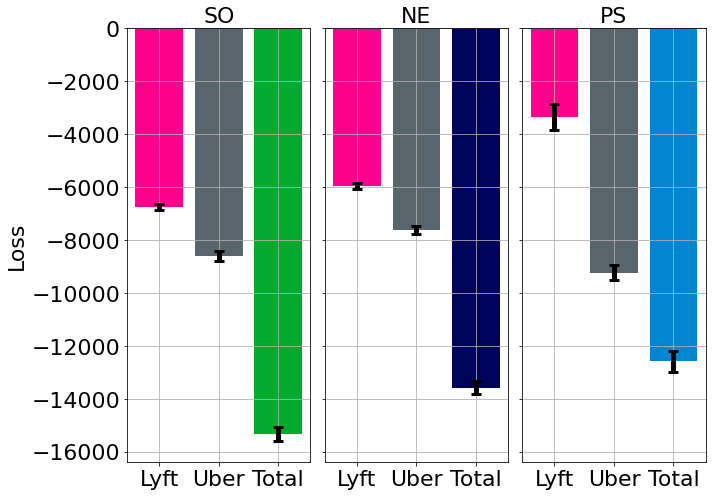

In [27]:
# where to store
filename='./figs/test_end_files/exp_f_change_rev_demand_price10.'
fs=24
bdd=1000 # how many points to average

lyft_rev_so=running_mean(loss_so_p1,N=100) # Nash - myopic
uber_rev_so=running_mean(loss_so_p2,N=100)
lyft_rev_so_final=np.mean(lyft_rev_so[-bdd:])
uber_rev_so_final=np.mean(uber_rev_so[-bdd:])
lyft_rev_var_so = np.std(lyft_rev_so[-bdd:])
uber_rev_var_so = np.std(uber_rev_so[-bdd:])
var=[lyft_rev_var_so, uber_rev_var_so]

lyft_rev_sgd=running_mean(loss_sgd_p1,N=100) # Nash - myopic
uber_rev_sgd=running_mean(loss_sgd_p2,N=100)
lyft_rev_sgd_final=np.mean(lyft_rev_sgd[-bdd:])
uber_rev_sgd_final=np.mean(uber_rev_sgd[-bdd:])
lyft_rev_var_sgd = np.std(lyft_rev_sgd[-bdd:])
uber_rev_var_sgd = np.std(uber_rev_sgd[-bdd:])
var=[lyft_rev_var_sgd, uber_rev_var_sgd]


lyft_rev_rgd=running_mean(loss_rgd_p1,N=100) # Nash - myopic
uber_rev_rgd=running_mean(loss_rgd_p2,N=100)
lyft_rev_rgd_final=np.mean(lyft_rev_rgd[-bdd:])
uber_rev_rgd_final=np.mean(uber_rev_rgd[-bdd:])
lyft_rev_var_rgd = np.std(lyft_rev_rgd[-bdd:])
uber_rev_var_rgd = np.std(uber_rev_rgd[-bdd:])
var=[lyft_rev_var_rgd, uber_rev_var_rgd]



fig, ax = plt.subplots(1, 3, figsize=(10, 7), sharey=True)

data=['Lyft Revenue', 'Uber Revenue']
data_=['Lyft Demand', 'Uber Demand']
x_pos = [i for i, _ in enumerate(data)]
x_pos_ = [i for i, _ in enumerate(data_)]

tot_so=lyft_rev_so_final+uber_rev_so_final
tot_ne=lyft_rev_sgd_final+uber_rev_sgd_final
tot_ps=lyft_rev_rgd_final+uber_rev_rgd_final

poa_ps=tot_ps/tot_so
poa_ne=tot_ne/tot_so

loss_tot_vec=lyft_rev_sgd[-bdd:]+uber_rev_sgd[-bdd:]
poa_vec_ne=[l/tot_so for l in loss_tot_vec]
poa_ne_mean=np.mean(np.asarray(poa_vec_ne))
poa_ne_var=np.std(np.asarray(poa_vec_ne))

loss_tot_vec=lyft_rev_rgd[-bdd:]+uber_rev_rgd[-bdd:]
poa_vec_ps=[l/tot_so for l in loss_tot_vec]
poa_ps_mean=np.mean(np.asarray(poa_vec_ps))
poa_ps_var=np.std(np.asarray(poa_vec_ps))

var_so=np.std(lyft_rev_so[-bdd:]+uber_rev_so[-bdd:])
var_sgd=np.std(lyft_rev_sgd[-bdd:]+uber_rev_sgd[-bdd:])
var_rgd=np.std(lyft_rev_rgd[-bdd:]+uber_rev_rgd[-bdd:])

vals_so=[lyft_rev_so_final, uber_rev_so_final,tot_so]
vals_ne=[lyft_rev_sgd_final, uber_rev_sgd_final,tot_ne]
vals_ps=[lyft_rev_rgd_final,uber_rev_rgd_final,tot_ps]

var_so=[lyft_rev_var_so, uber_rev_var_so,var_so]
var_ne=[lyft_rev_var_sgd, uber_rev_var_sgd,var_sgd]
var_ps=[lyft_rev_var_rgd, uber_rev_var_rgd,var_rgd]


dic={key: val for key, val in zip(data,vals)}
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].set_ylabel("Loss", fontsize=fs-2)


ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['Lyft','Uber','Total'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax[0].bar([0,1,2], vals_so , yerr=var_so, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:kelly green'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )

ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['Lyft','Uber','Total'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax[1].bar([0,1,2], vals_ne , yerr=var_ne, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:dark blue'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )

ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels(['Lyft','Uber','Total'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax[2].bar([0,1,2], vals_ps , yerr=var_ps, color=['xkcd:hot pink', 'xkcd:slate grey','xkcd:cerulean'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )
#ax[2].set_title("Performatively Stable", fontsize=fs-2)
#ax[1].set_title("Nash Equilibrium", fontsize=fs-2)
#ax[0].set_title("Social Optimum", fontsize=fs-2)

ax[2].set_title("PS", fontsize=fs-2)
ax[1].set_title("NE", fontsize=fs-2)
ax[0].set_title("SO", fontsize=fs-2)

plt.tick_params(labelsize=fs-2)
ax[0].tick_params(labelsize=fs-2)
ax[2].tick_params(labelsize=fs-2)
ax[1].tick_params(labelsize=fs-2)
plt.tight_layout()
SAVE=0
filename='./figs/test_end_files/loss_so_comp_alt.'
if SAVE:
    for tag in ['pdf', 'png']:
        plt.savefig(filename+tag, dpi=300, bbox_inches='tight', transparent=True)

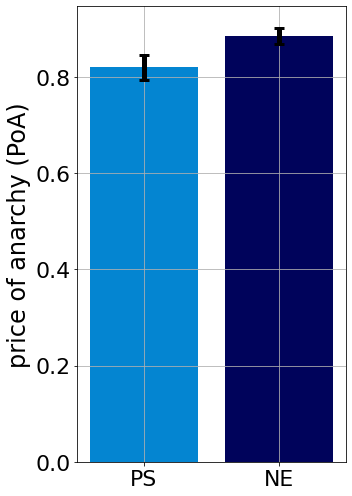

In [29]:
# where to store
filename='./figs/test_end_files/exp_f_change_rev_demand_price10.'
fs=24
bdd=1000 # how many points to average

lyft_rev_so=running_mean(loss_so_p1,N=100) # Nash - myopic
uber_rev_so=running_mean(loss_so_p2,N=100)
lyft_rev_so_final=np.mean(lyft_rev_so[-bdd:])
uber_rev_so_final=np.mean(uber_rev_so[-bdd:])
lyft_rev_var_so = np.std(lyft_rev_so[-bdd:])
uber_rev_var_so = np.std(uber_rev_so[-bdd:])
var=[lyft_rev_var_so, uber_rev_var_so]

lyft_rev_sgd=running_mean(loss_sgd_p1,N=100) # Nash - myopic
uber_rev_sgd=running_mean(loss_sgd_p2,N=100)
lyft_rev_sgd_final=np.mean(lyft_rev_sgd[-bdd:])
uber_rev_sgd_final=np.mean(uber_rev_sgd[-bdd:])
lyft_rev_var_sgd = np.std(lyft_rev_sgd[-bdd:])
uber_rev_var_sgd = np.std(uber_rev_sgd[-bdd:])
var=[lyft_rev_var_sgd, uber_rev_var_sgd]


lyft_rev_rgd=running_mean(loss_rgd_p1,N=100) # Nash - myopic
uber_rev_rgd=running_mean(loss_rgd_p2,N=100)
lyft_rev_rgd_final=np.mean(lyft_rev_rgd[-bdd:])
uber_rev_rgd_final=np.mean(uber_rev_rgd[-bdd:])
lyft_rev_var_rgd = np.std(lyft_rev_rgd[-bdd:])
uber_rev_var_rgd = np.std(uber_rev_rgd[-bdd:])
var=[lyft_rev_var_rgd, uber_rev_var_rgd]



fig, ax = plt.subplots(1, 1, figsize=(5, 7), sharey=True)

data=['Lyft Revenue', 'Uber Revenue']
data_=['Lyft Demand', 'Uber Demand']
x_pos = [i for i, _ in enumerate(data)]
x_pos_ = [i for i, _ in enumerate(data_)]

tot_so=lyft_rev_so_final+uber_rev_so_final
tot_ne=lyft_rev_sgd_final+uber_rev_sgd_final
tot_ps=lyft_rev_rgd_final+uber_rev_rgd_final

poa_ps=tot_ps/tot_so
poa_ne=tot_ne/tot_so

loss_tot_vec=lyft_rev_sgd[-bdd:]+uber_rev_sgd[-bdd:]
poa_vec_ne=[l/tot_so for l in loss_tot_vec]
poa_ne_mean=np.mean(np.asarray(poa_vec_ne))
poa_ne_var=np.std(np.asarray(poa_vec_ne))

loss_tot_vec=lyft_rev_rgd[-bdd:]+uber_rev_rgd[-bdd:]
poa_vec_ps=[l/tot_so for l in loss_tot_vec]
poa_ps_mean=np.mean(np.asarray(poa_vec_ps))
poa_ps_var=np.std(np.asarray(poa_vec_ps))

poa=[poa_ps_mean, poa_ne_mean]
poa_var=[poa_ps_var, poa_ne_var]


dic={key: val for key, val in zip(data,vals)}
ax.grid(True)


ax.set_ylabel("price of anarchy (PoA)", fontsize=fs)


ax.set_xticks([0,1])
ax.set_xticklabels(['PS','NE'], fontsize=fs-2) #'Lyft NE','Uber NE','NE','Lyft PS','Uber PS','PS']
ax.bar([0,1], poa , yerr=poa_var, color=['xkcd:cerulean', 'xkcd:dark blue'],
          error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'),
        )



plt.tick_params(labelsize=fs-2)

plt.tight_layout()
SAVE=0
filename='./figs/test_end_files/poa_rideshare.'
if SAVE:
    for tag in ['pdf', 'png']:
        plt.savefig(filename+tag, dpi=300, bbox_inches='tight', transparent=True)

## Experiment 3: Effects of Competition
This code generates Figure 3.

The ```MYOPIC``` flag determines whether the players are fully myopic meaning 
$$g_i^t=(\lambda_i I)^\top x_i^t-\frac{1}{2}\zeta_i^t$$
The ```perform_sgd``` flag in combination with the ```MYOPIC``` determines whether the players are partially myopic. That is if ```MYOPIC==False``` and ```perform_sgd[i]==False``` then player ```i``` is partially myopic in which case $$g_i^t=-(A_i-\lambda_i I)^\top x_i^t-\frac{1}{2}\zeta_i^t$$ 

```tot_rev``` should be zero or one. If its zero, then you get the change in revenue from nominal. If its one, you get the total revenue given the base price.

In [30]:
# run base nash case
dic_sgd=ddgame.runSGD(x0,eta=0.001,BATCH=BATCH,MAXITER=MAXITER, perform_sgd=[True,True], MYOPIC=False, tot_rev=0)
setting='Lyft and Uber Myopic'

if setting=='Lyft and Uber Myopic':
    MYOPIC=True
    perform_sgd=[False,False]
elif setting=='Uber Myopic Only':
    MYOPIC=True
    perform_sgd=[True,False]
elif setting=='Lyft Myopic Only':
    MYOPIC=True
    perform_sgd=[False,True]
elif setting=='Lyft and Uber Partially Myopic':
    MYOPIC=False
    perform_sgd=[False,False]
elif setting=='Uber Partially Myopic Only':
    MYOPIC=False
    perform_sgd=[True,False]
elif setting=='Lyft Partially Myopic Only':
    MYOPIC=False
    perform_sgd=[False,True]

dic_sgd_ignore=ddgame.runSGD(x0,eta=0.001,BATCH=BATCH,MAXITER=MAXITER, perform_sgd=perform_sgd, MYOPIC=MYOPIC, tot_rev=0) 

Price we are running at :  10
Price we are running at :  10


In [31]:
# store relevant data and compute data frames
rev_ig_p1_loc=dic_sgd_ignore['revenue_by_loc_p1']
rev_ig_p2_loc=dic_sgd_ignore['revenue_by_loc_p2']

rev_p1_loc=dic_sgd['revenue_by_loc_p1']
rev_p2_loc=dic_sgd['revenue_by_loc_p2']

rev_ig_p1=dic_sgd_ignore['revenue_total_p1']
rev_ig_p2=dic_sgd_ignore['revenue_total_p2']

rev_p1=dic_sgd['revenue_total_p1']
rev_p2=dic_sgd['revenue_total_p2']

demand_ig_p1=dic_sgd_ignore['demand_p1']
demand_ig_p2=dic_sgd_ignore['demand_p2']

demand_p1=dic_sgd['demand_p1']
demand_p2=dic_sgd['demand_p2']

x_sgd=np.asarray(dic_sgd['x'])
x_sgd_ig=np.asarray(dic_sgd_ignore['x'])

lyft_avg_price=np.mean(x_sgd[-100:,0,:], axis=0)
uber_avg_price=np.mean(x_sgd[-100:,1,:], axis=0)

df_all_u,df_all_l=ddgame.get_dataframe_for_plot(rev_ig_p1, rev_ig_p2, demand_ig_p1, demand_ig_p2, rev_ig_p1_loc, rev_ig_p2_loc, 
                                                rev_p1, rev_p2, demand_p1, demand_p2, rev_p1_loc, rev_p2_loc,x_sgd,x_sgd_ig,
                                                shift=4900, shift_amt=0.002, mean_back=100, scale=1)

Text(0, 0.5, 'average price')

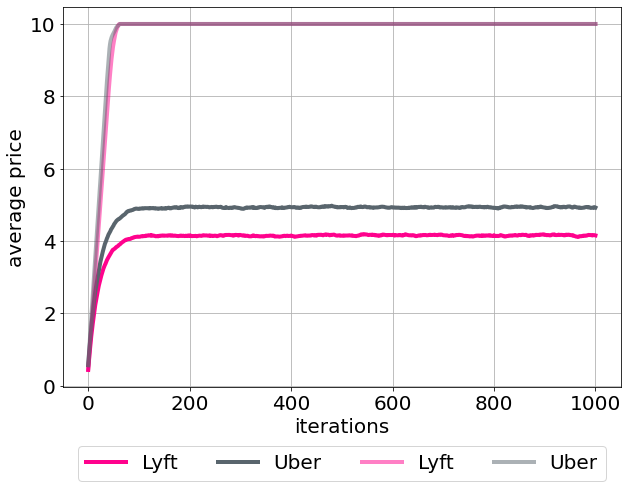

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
lyft_avg_price=np.mean(x_sgd[:,0,:], axis=1)
uber_avg_price=np.mean(x_sgd[:,1,:], axis=1)

lyft_avg_price_=np.mean(x_sgd_ig[:,0,:], axis=1)
uber_avg_price_=np.mean(x_sgd_ig[:,1,:], axis=1)

op=[1.0,0.5]
plt.plot(lyft_avg_price, color='xkcd:hot pink', linewidth=4, label='Lyft')
plt.plot(uber_avg_price, color='xkcd:slate grey', linewidth=4, label='Uber')
plt.plot(lyft_avg_price_, color='xkcd:hot pink', linewidth=4, label='Lyft', alpha=0.5)
plt.plot(uber_avg_price_, color='xkcd:slate grey', linewidth=4, label='Uber', alpha=0.5)
ax.grid(True)
ax.legend(fontsize=20,loc='center',bbox_to_anchor=(0.5,-0.2),ncol=6)
plt.tick_params(labelsize=20)
plt.xlabel('iterations', fontsize=20)
plt.ylabel('average price', fontsize=20)

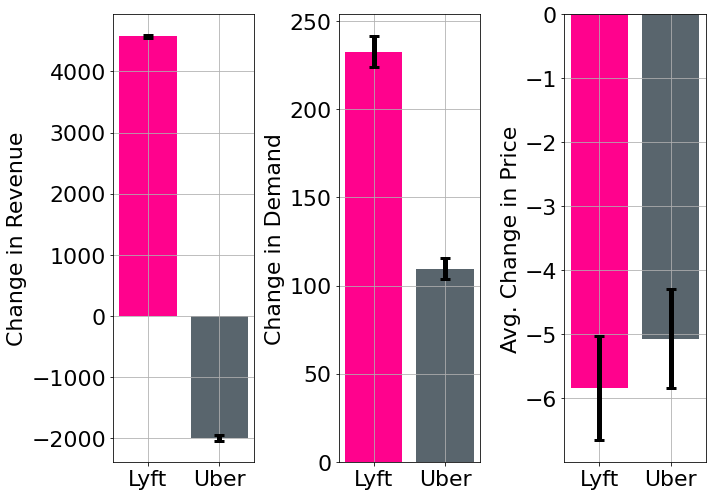

In [33]:
# where to store
filename='./figs/test_end_files/exp_f_change_rev_demand_price10.'
SAVE=0
fs=24
bdd=100 # how many points to average

lyft_rev=running_mean(rev_p1-rev_ig_p1,N=100) # Nash - myopic
uber_rev=running_mean(rev_p2-rev_ig_p2,N=100)
lyft_rev_final=np.mean(lyft_rev[-bdd:])
uber_rev_final=np.mean(uber_rev[-bdd:])
lyft_rev_var = np.std(lyft_rev[-bdd:])
uber_rev_var = np.std(uber_rev[-bdd:])
var=[lyft_rev_var, uber_rev_var]

lyft_demand=running_mean(demand_p1-demand_ig_p1,N=100)
uber_demand=running_mean(demand_p2-demand_ig_p2,N=100)
lyft_demand_final=np.mean(lyft_demand[-bdd:])
uber_demand_final=np.mean(uber_demand[-bdd:])
lyft_demand_var = np.std(lyft_demand[-bdd:])
uber_demand_var = np.std(uber_demand[-bdd:])
var_=[lyft_demand_var, uber_demand_var]

lyft_avg_price=np.mean(x_sgd[-100:,0,:]-x_sgd_ig[-100:,0,:])
uber_avg_price=np.mean(x_sgd[-100:,1,:]-x_sgd_ig[-100:,1,:])
lyft_var_price=np.std(x_sgd[-100:,0,:]-x_sgd_ig[-100:,0,:])
uber_var_price=np.std(x_sgd[-100:,1,:]-x_sgd_ig[-100:,1,:])
_var=[lyft_var_price, uber_var_price]

fig, ax = plt.subplots(1, 3, figsize=(10, 7))

data=['Lyft Revenue', 'Uber Revenue']
data_=['Lyft Demand', 'Uber Demand']
x_pos = [i for i, _ in enumerate(data)]
x_pos_ = [i for i, _ in enumerate(data_)]

vals=[lyft_rev_final, uber_rev_final]
vals_=[lyft_demand_final, uber_demand_final]
_vals=[lyft_avg_price,uber_avg_price]

dic={key: val for key, val in zip(data,vals)}
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].set_ylabel("Change in Revenue", fontsize=fs-2)
ax[1].set_ylabel("Change in Demand", fontsize=fs-2)
ax[2].set_ylabel("Avg. Change in Price", fontsize=fs-2)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['Lyft','Uber'], fontsize=fs-2)
ax[0].bar([0,1], [val for key, val in sorted(dic.items())], yerr=var, color=['xkcd:hot pink', 'xkcd:slate grey'],error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'))
ax[1].bar(x_pos_, vals_,yerr=var_, color=['xkcd:hot pink', 'xkcd:slate grey'],error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'))
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['Lyft','Uber'], fontsize=fs-2)

ax[2].bar(x_pos_, _vals,yerr=_var, color=['xkcd:hot pink', 'xkcd:slate grey'],error_kw=dict(lw=5, capsize=5, capthick=3, color='xkcd:light pink'))
ax[2].set_xticks([0,1])
ax[2].set_xticklabels(['Lyft','Uber'], fontsize=fs-2)

plt.tick_params(labelsize=fs-2)
ax[0].tick_params(labelsize=fs-2)
ax[2].tick_params(labelsize=fs-2)
ax[1].tick_params(labelsize=fs-2)
plt.tight_layout()

if SAVE:
    for tag in ['pdf', 'png']:
        plt.savefig(filename+tag, dpi=300, bbox_inches='tight', transparent=True)
    
    

Text(0, 0.5, 'change in revenue [$\\Delta$ \\$]')

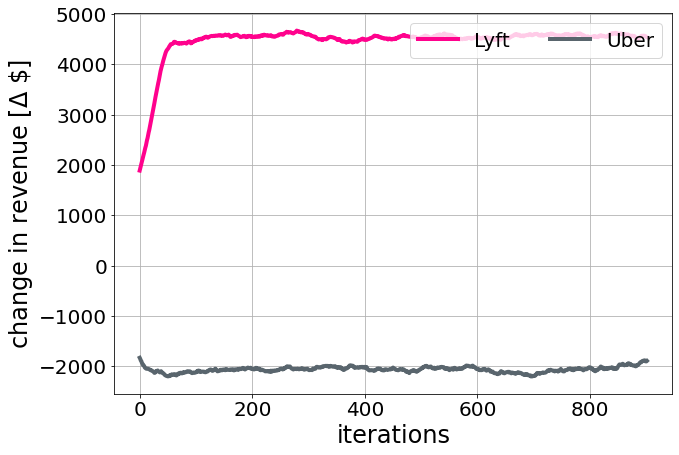

In [34]:
## Plot change in revenue over time

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
lyft_rev=running_mean(rev_p1-rev_ig_p1,N=100)
uber_rev=running_mean(rev_p2-rev_ig_p2,N=100)
lyft_rev_final=np.mean(lyft_rev[-100:])
uber_rev_final=np.mean(uber_rev[-100:])

lyft_demand=running_mean(demand_p1-demand_ig_p1,N=100)
uber_demand=running_mean(demand_p2-demand_ig_p2,N=100)
lyft_demand_final=np.mean(lyft_demand[-100:])
uber_demand_final=np.mean(uber_demand[-100:])
fs=24
op=[1.0,0.5]
plt.plot(lyft_rev, color='xkcd:hot pink', linewidth=4, label='Lyft')
plt.plot(uber_rev, color='xkcd:slate grey', linewidth=4, label='Uber')
ax.grid(True)
ax.legend(fontsize=20,loc='upper right',ncol=2)
plt.tick_params(labelsize=20)
plt.xlabel('iterations', fontsize=fs)
plt.ylabel(r'change in revenue [$\Delta$ \$]', fontsize=fs)



#### Plot the price changes per location

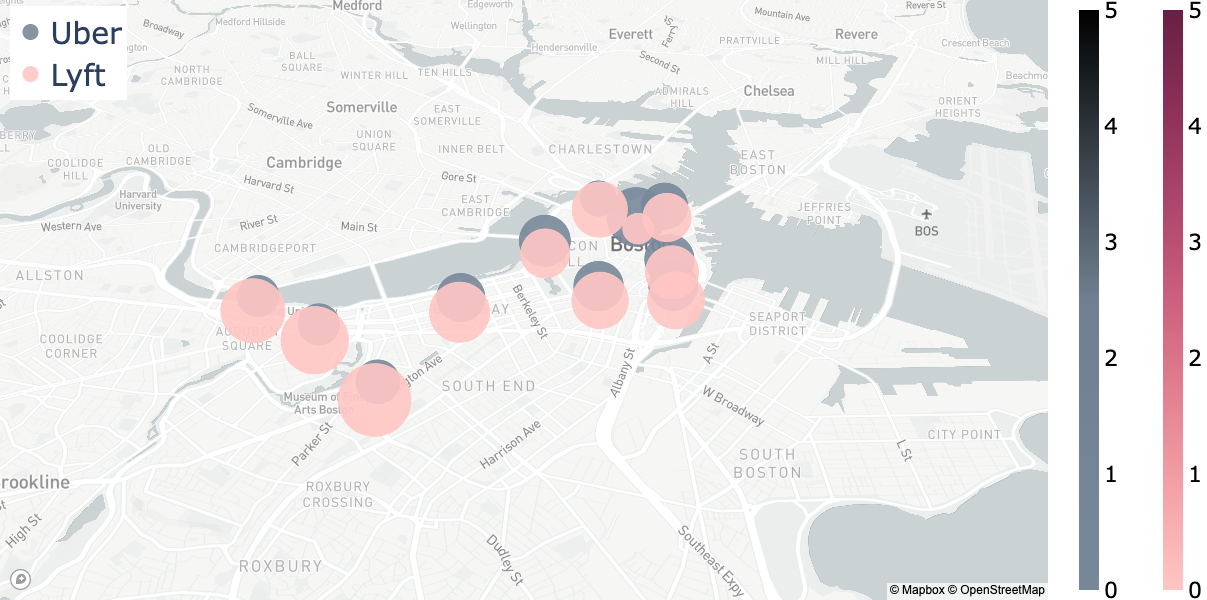

In [35]:
fname="figs/test_end_files/price_change_price10_myopic."
SAVE=0
df_all_sort_comp_l=df_all_l.sort_values(by=['price_change'], ascending=False)
df_all_sort_comp_u=df_all_u.sort_values(by=['price_change'], ascending=False)
fs_cb=22
import plotly.graph_objects as go
fig = go.Figure()
scale=10
f1=go.Scattermapbox(
    lat=df_all_sort_comp_u["centroid_lat"],
        lon=df_all_sort_comp_u["centroid_lon"],
        mode='markers',
        marker=go.scattermapbox.Marker(#YlOrRd
            size=np.abs(df_all_sort_comp_u["price_change"])*scale, color=df_all_sort_comp_u["price_change"],colorscale= ["lightslategrey", "slategray", "black"],symbol = 'circle', opacity=0.9,
            showscale=True, 
cmax=5, #np.max([np.max(df_all_sort_comp_l["price_change"]),np.max(df_all_sort_comp_u["price_change"])])+5,
            cmin=0*np.min([np.min(df_all_sort_comp_l["price_change"]),np.min(df_all_sort_comp_u["price_change"])]),colorbar=dict(thickness=20,
                           ticklen=3, tickcolor='black',
                           tickfont=dict(size=fs_cb, color='black'))
        ),
        text="Uber",name="Uber"
    
        
    )
f2=go.Scattermapbox(
    lat=df_all_sort_comp_l["centroid_lat"],
        lon=df_all_sort_comp_l["centroid_lon"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=np.abs(df_all_sort_comp_l["price_change"])*scale, color=df_all_sort_comp_l["price_change"],colorscale= 'Burg',symbol = 'circle', opacity=0.9,
            showscale=True,
cmax=5, #np.max([np.max(df_all_sort_comp_l["price_change"]),np.max(df_all_sort_comp_u["price_change"])]),
cmin=0*np.min([np.min(df_all_sort_comp_l["price_change"]),np.min(df_all_sort_comp_u["price_change"])]),colorbar=dict(thickness=20,
                           ticklen=3, tickcolor='black',
                           tickfont=dict(size=fs_cb, color='black'))
        ),
        text="Lyft",
    name="Lyft"
        
    )
fig.add_trace(f1)
f2.marker.colorbar.x = 1.1 # Here
fig.add_trace(f2)
fig.update_layout(coloraxis_colorbar_x=-0.15)


fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken="pk.eyJ1IjoicmF0bGlmZmxqIiwiYSI6ImNqOGJ4cm8wcjAzN3QyeG1zcnZvMjB5bGUifQ.iRkpBPE-WANBkVc9ffI8ng",
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=df_all_sort_comp_u["centroid_lat"][0]-0.0175,
            lon=df_all_sort_comp_u["centroid_lon"][0]-0.021
        ),
        pitch=50,
        zoom=13.75
    ),

)

fig.update_geos(fitbounds="locations", resolution=110,)
fig.update_layout(height=600, width=1200,margin={"r":0,"t":0,"l":0,"b":0},legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",title_font_size=30, title="",
    x=0.01, orientation="v",bgcolor="white",font=dict( #"rgba(0,0,0,0)"
            size=30,
        ),
))
if SAVE:
    for tag in ['pdf','png']:
        fig.write_image(fname+tag)

fig.show()

#### Plot the demand change per location

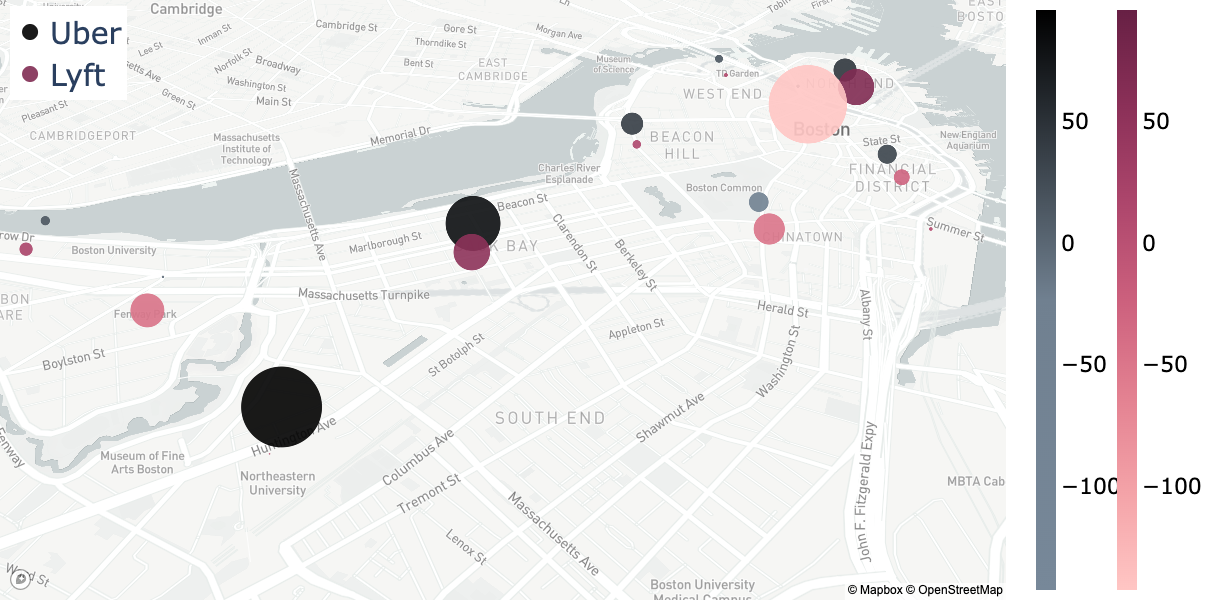

In [36]:
fname="figs/test_end_files/demand_change_price10_myopic."
SAVE=0

df_all_sort_comp_l=df_all_l.sort_values(by=['demand_change'], ascending=False)
df_all_sort_comp_u=df_all_u.sort_values(by=['demand_change'], ascending=False)
fs_cb=22
import plotly.graph_objects as go
fig = go.Figure()
scale=0.75
f1=go.Scattermapbox(
    lat=df_all_sort_comp_u["centroid_lat"],
        lon=df_all_sort_comp_u["centroid_lon"],
        mode='markers',
        marker=go.scattermapbox.Marker(#YlOrRd
            size=np.abs(df_all_sort_comp_u["demand_change"])*scale, color=df_all_sort_comp_u["demand_change"],colorscale= ["lightslategrey", "slategray", "black"],symbol = 'circle', opacity=0.9,
            showscale=True, 
cmax=np.max([np.max(df_all_sort_comp_l["demand_change"]),np.max(df_all_sort_comp_u["demand_change"])]),
            cmin=np.min([np.min(df_all_sort_comp_l["demand_change"]),np.min(df_all_sort_comp_u["demand_change"])]),colorbar=dict(thickness=20,
                           ticklen=3, tickcolor='black',
                           tickfont=dict(size=fs_cb, color='black'))
        ),
        text="Uber",name="Uber"
    
        
    )
f2=go.Scattermapbox(
    lat=df_all_sort_comp_l["centroid_lat"],
        lon=df_all_sort_comp_l["centroid_lon"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=np.abs(df_all_sort_comp_l["demand_change"])*scale, color=df_all_sort_comp_l["demand_change"],colorscale= 'Burg',symbol = 'circle', opacity=0.9,
            showscale=True,
cmax=np.max([np.max(df_all_sort_comp_l["demand_change"]),np.max(df_all_sort_comp_u["demand_change"])]),
cmin=np.min([np.min(df_all_sort_comp_l["demand_change"]),np.min(df_all_sort_comp_u["demand_change"])]),colorbar=dict(thickness=20,
                           ticklen=3, tickcolor='black',
                           tickfont=dict(size=fs_cb, color='black'))
        ),
        text="Lyft",
    name="Lyft"
        
    )
fig.add_trace(f1)
f2.marker.colorbar.x = 1.1 # Here
fig.add_trace(f2)
fig.update_layout(coloraxis_colorbar_x=-0.15)


fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken="pk.eyJ1IjoicmF0bGlmZmxqIiwiYSI6ImNqOGJ4cm8wcjAzN3QyeG1zcnZvMjB5bGUifQ.iRkpBPE-WANBkVc9ffI8ng",
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=df_all_sort_comp_u["centroid_lat"][0]-0.0175,
            lon=df_all_sort_comp_u["centroid_lon"][0]-0.021
        ),
        pitch=50,
        zoom=13.75
    ),

)

fig.update_geos(fitbounds="locations", resolution=110,)
fig.update_layout(height=600, width=1200,margin={"r":0,"t":0,"l":0,"b":0},legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",title_font_size=30, title="",
    x=0.01, orientation="v",bgcolor="white",font=dict( #"rgba(0,0,0,0)"
            size=30,
        ),
))
   
if SAVE:
    for tag in ['pdf','png']:
        fig.write_image(fname+tag)

fig.show()


#### Plot the revenue change from nominal by location

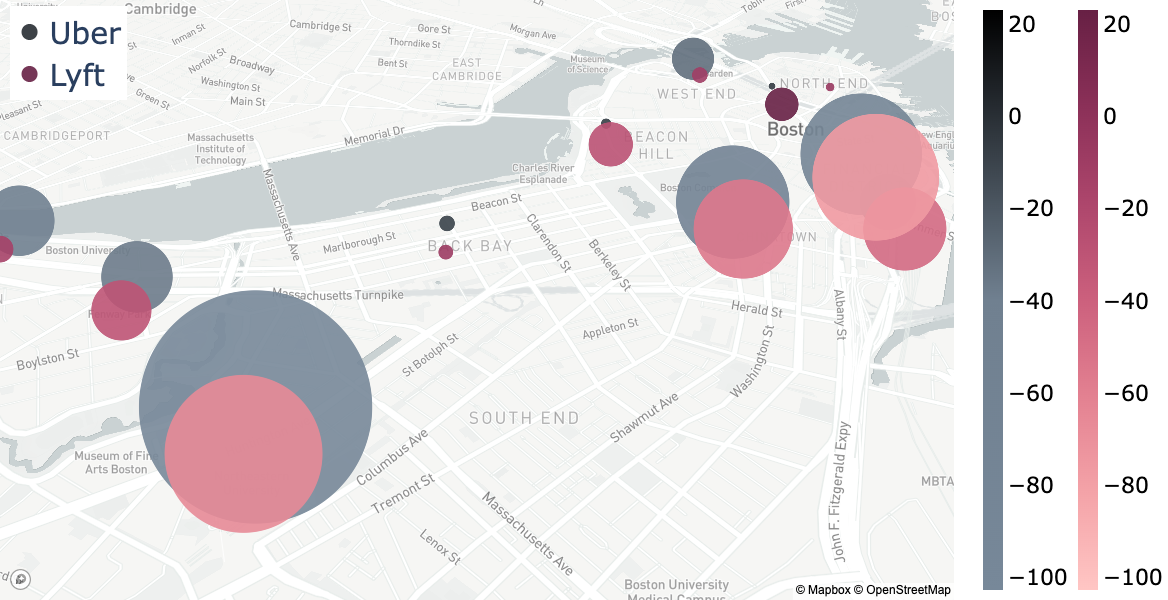

In [18]:
fname="figs/test_end_files/revenue_change_price10_myopic."
df_all_sort_comp_l=df_all_l.sort_values(by=['revenue_change'], ascending=False)
df_all_sort_comp_u=df_all_u.sort_values(by=['revenue_change'], ascending=False)
uberscale=["lightslategrey", "slategray", "black"]
import plotly.graph_objects as go
fig = go.Figure()
scale=2
f1=go.Scattermapbox(
        lat=df_all_sort_comp_u["centroid_lat"],
        lon=df_all_sort_comp_u["centroid_lon"],
        mode='markers',
        marker=go.scattermapbox.Marker(#YlOrRd
            size=np.abs(df_all_sort_comp_u["revenue_change"])*scale, color=df_all_sort_comp_u["revenue_change"],colorscale= uberscale,symbol = 'circle', opacity=0.9,
            showscale=True, 
cmax=np.max([np.max(df_all_sort_comp_l["revenue_change"]),np.max(df_all_sort_comp_u["revenue_change"])]),
cmin=np.min([np.min(df_all_sort_comp_l["revenue_change"]),np.min(df_all_sort_comp_u["revenue_change"])]),colorbar=dict(thickness=20,
                           ticklen=2, tickcolor='black',
                           tickfont=dict(size=22, color='black'))
        ),
        text="Uber",name="Uber"
    )
f2=go.Scattermapbox(
        lat=df_all_sort_comp_l["centroid_lat"],
        lon=df_all_sort_comp_l["centroid_lon"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=np.abs(df_all_sort_comp_l["revenue_change"])*scale, color=df_all_sort_comp_l["revenue_change"],colorscale= 'Burg',symbol = 'circle', opacity=0.9,
            showscale=True,
cmax=np.max([np.max(df_all_sort_comp_l["revenue_change"]),np.max(df_all_sort_comp_u["revenue_change"])]),
cmin=np.min([np.min(df_all_sort_comp_l["revenue_change"]),np.min(df_all_sort_comp_u["revenue_change"])]),colorbar=dict(thickness=20,
                           ticklen=2, tickcolor='black',
                           tickfont=dict(size=22, color='black'))
        ),
        text="Lyft",
    name="Lyft"
    )
fig.add_trace(f1)
f2.marker.colorbar.x = 1.12 # Here
fig.add_trace(f2)
fig.update_layout(coloraxis_colorbar_x=-0.2)

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken="pk.eyJ1IjoicmF0bGlmZmxqIiwiYSI6ImNqOGJ4cm8wcjAzN3QyeG1zcnZvMjB5bGUifQ.iRkpBPE-WANBkVc9ffI8ng",
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=df_all_sort_comp_u["centroid_lat"][0]-0.0175,
            lon=df_all_sort_comp_u["centroid_lon"][0]-0.021
        ),
        pitch=50,
        zoom=13.75
    )
)

fig.update_geos(fitbounds="locations", resolution=110,)
fig.update_layout(height=600, width=1200,margin={"r":0,"t":0,"l":0,"b":0},legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",title_font_size=30, title="",
    x=0.01, orientation="v",bgcolor="white",font=dict( #"rgba(0,0,0,0)"
            size=30,
        ),
))
if SAVE:    
    for tag in ['pdf','png']:
        fig.write_image(fname+tag)

fig.show()